Dataset : https://www.kaggle.com/datasets/alessiocorrado99/animals10

In [2]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [3]:
# Path ke direktori dataset
dataset_path = '/content/dataset/raw-img'

# Loop melalui setiap folder di dalam direktori dataset
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)

    if os.path.isdir(folder_path):
        print(f"\nFolder: {folder_name}")

        # Mengambil sampel 1 gambar dari setiap folder
        sample_images = os.listdir(folder_path)[:1]

        for image_name in sample_images:
            image_path = os.path.join(folder_path, image_name)

            # Membuka gambar menggunakan PIL
            img = Image.open(image_path)

            # Mendapatkan resolusi gambar
            width, height = img.size

            print(f"  - Gambar: {image_name}, Resolusi: {width} x {height}")

            # Menampilkan sampel gambar
            display(img)

            # Menutup gambar
            img.close()



Folder: elefante
  - Gambar: OIP--m1aerbTHlu_7bsA7MBOrAHaFj.jpeg, Resolusi: 300 x 225

Folder: ragno
  - Gambar: OIP-i4BbFrHYY_cKIotQbHhdFQHaE8.jpeg, Resolusi: 300 x 200

Folder: gatto
  - Gambar: erik-jan-leusink-126918-unsplash.jpg, Resolusi: 4272 x 2848

Folder: pecora
  - Gambar: eb33b1092cf4043ed1584d05fb1d4e9fe777ead218ac104497f5c978a6eab2b0_640.jpg, Resolusi: 640 x 426

Folder: cavallo
  - Gambar: OIP-fYRRjv8buSYASCeglKvHmwHaJh.jpeg, Resolusi: 234 x 300

Folder: farfalla
  - Gambar: e030b2092ce90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg, Resolusi: 425 x 640

Folder: mucca
  - Gambar: OIP-f9dNFlxOGyQLrkQ7FeO9EQHaEK.jpeg, Resolusi: 300 x 169

Folder: scoiattolo
  - Gambar: OIP-WB1QjlIqEkZaFTfn048mgAHaEn.jpeg, Resolusi: 300 x 187

Folder: cane
  - Gambar: OIP-8hQP-ZGHLofJeddNVwiYhgHaJ4.jpeg, Resolusi: 225 x 300

Folder: gallina
  - Gambar: OIP-3n3lP6d4gSvLREoeibv6vwHaFh.jpeg, Resolusi: 300 x 224


Total Gambar per Kelas:
mucca: 1866 gambar
ragno: 4821 gambar
gatto: 1668 gambar
farfalla: 2112 gambar
scoiattolo: 1862 gambar
pecora: 1820 gambar
gallina: 3098 gambar
elefante: 1446 gambar
cavallo: 2623 gambar
cane: 4863 gambar


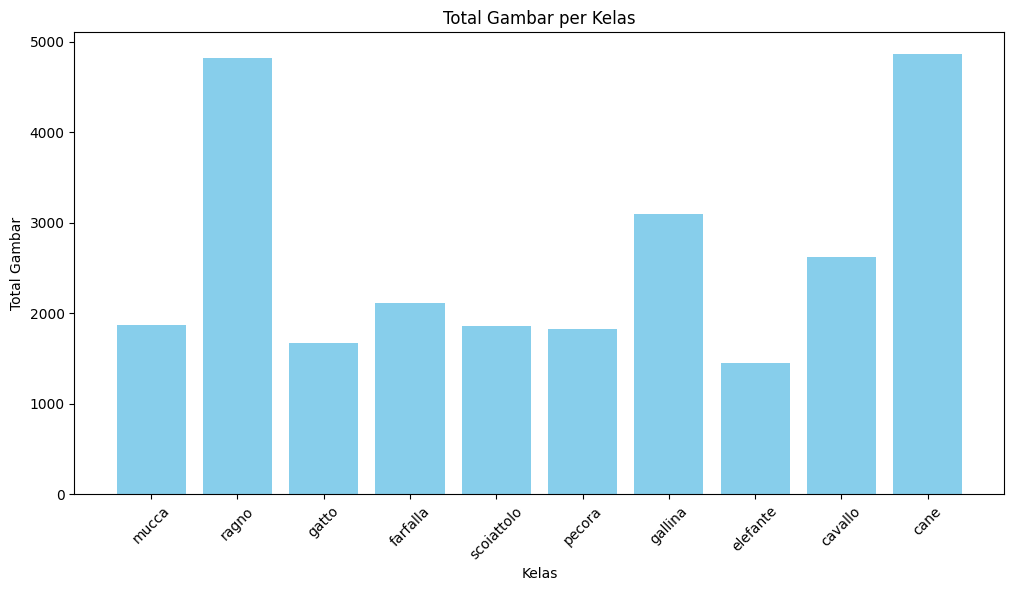

In [ ]:
# Path ke direktori dataset
dataset_path = '/content/dataset/raw-img'

# Inisialisasi variabel untuk menyimpan total gambar setiap kelas
total_images_per_class = {}

# Loop melalui setiap folder di dalam direktori dataset
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)

    if os.path.isdir(folder_path):
        # Menghitung total gambar dalam setiap folder
        total_images = len(os.listdir(folder_path))

        # Menambahkan informasi ke dalam dictionary
        total_images_per_class[folder_name] = total_images

# Mencetak total gambar setiap kelas
print("Total Gambar per Kelas:")
for class_name, total_images in total_images_per_class.items():
    print(f"{class_name}: {total_images} gambar")

# Menampilkan data dalam bentuk grafik
plt.figure(figsize=(12, 6))
plt.bar(total_images_per_class.keys(), total_images_per_class.values(), color='skyblue')
plt.xlabel('Kelas')
plt.ylabel('Total Gambar')
plt.title('Total Gambar per Kelas')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Membagi dataset menjadi train set (80%) dan validation set (20%)
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    '/content/dataset/raw-img',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/dataset/raw-img',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.
94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
target = 0.96

class TargetCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') is not None and logs.get('val_accuracy') is not None:
            if logs.get('accuracy') >= target and logs.get('val_accuracy') >= target:
                print(f"Accuracy and val_accuracy >= {target:.3%} of targets. Training stopped.")
                self.model.stop_training = True

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

callback = TargetCallback()

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[callback, reduce_lr],
    shuffle=True
)

Epoch 1/30
328/328 [==============================] - 97s 295ms/step - loss: 0.2490 - accuracy: 0.9328 - val_loss: 0.1780 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 2/30
328/328 [==============================] - 81s 248ms/step - loss: 0.1337 - accuracy: 0.9596 - val_loss: 0.1950 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 3/30
328/328 [==============================] - 85s 259ms/step - loss: 0.0790 - accuracy: 0.9755 - val_loss: 0.2324 - val_accuracy: 0.9444 - lr: 0.0010
Epoch 4/30
328/328 [==============================] - 91s 277ms/step - loss: 0.0510 - accuracy: 0.9845 - val_loss: 0.2252 - val_accuracy: 0.9450 - lr: 0.0010
Epoch 5/30
328/328 [==============================] - 88s 268ms/step - loss: 0.0347 - accuracy: 0.9880 - val_loss: 0.2970 - val_accuracy: 0.9434 - lr: 0.0010
Epoch 6/30
328/328 [==============================] - 79s 239ms/step - loss: 0.0323 - accuracy: 0.9892 - val_loss: 0.3070 - val_accuracy: 0.9446 - lr: 0.0010
Epoch 7/30
328/328 [==============================] 

Val_accuracy tetap stabil selama proses pelatihan, dan peningkatan mungkin dapat dicapai dengan menambahkan lebih banyak data pada setiap kategori terkait. Walaupun telah mencoba teknik augmentasi data, regulasi (seperti L2 dan dropout), dan lainnya, namun val_accuracy tetap stabil pada tingkat tertentu.

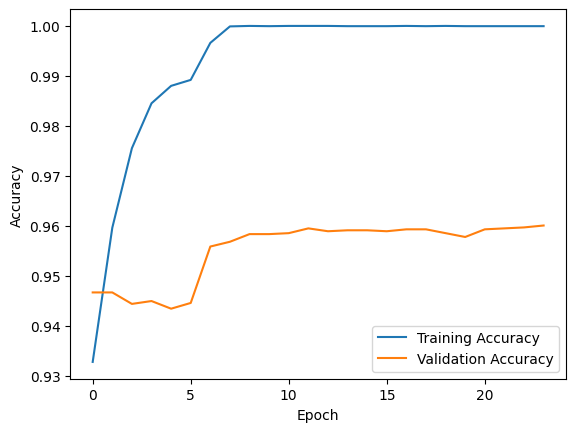

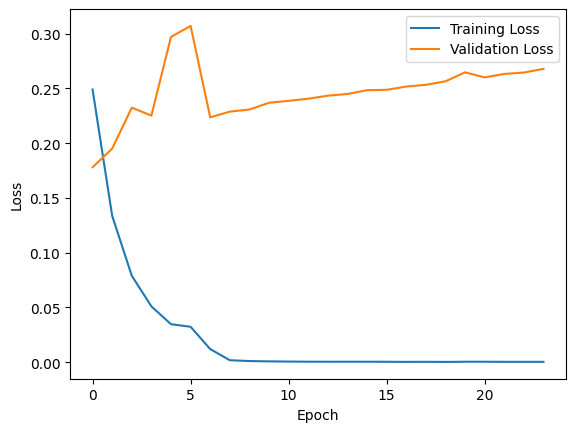

In [ ]:
# Plot akurasi dan loss model
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Menyimpan model ke dalam format TF-Lite
model.save('content/model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('content/model.tflite', 'wb') as f:
    f.write(tflite_model)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
